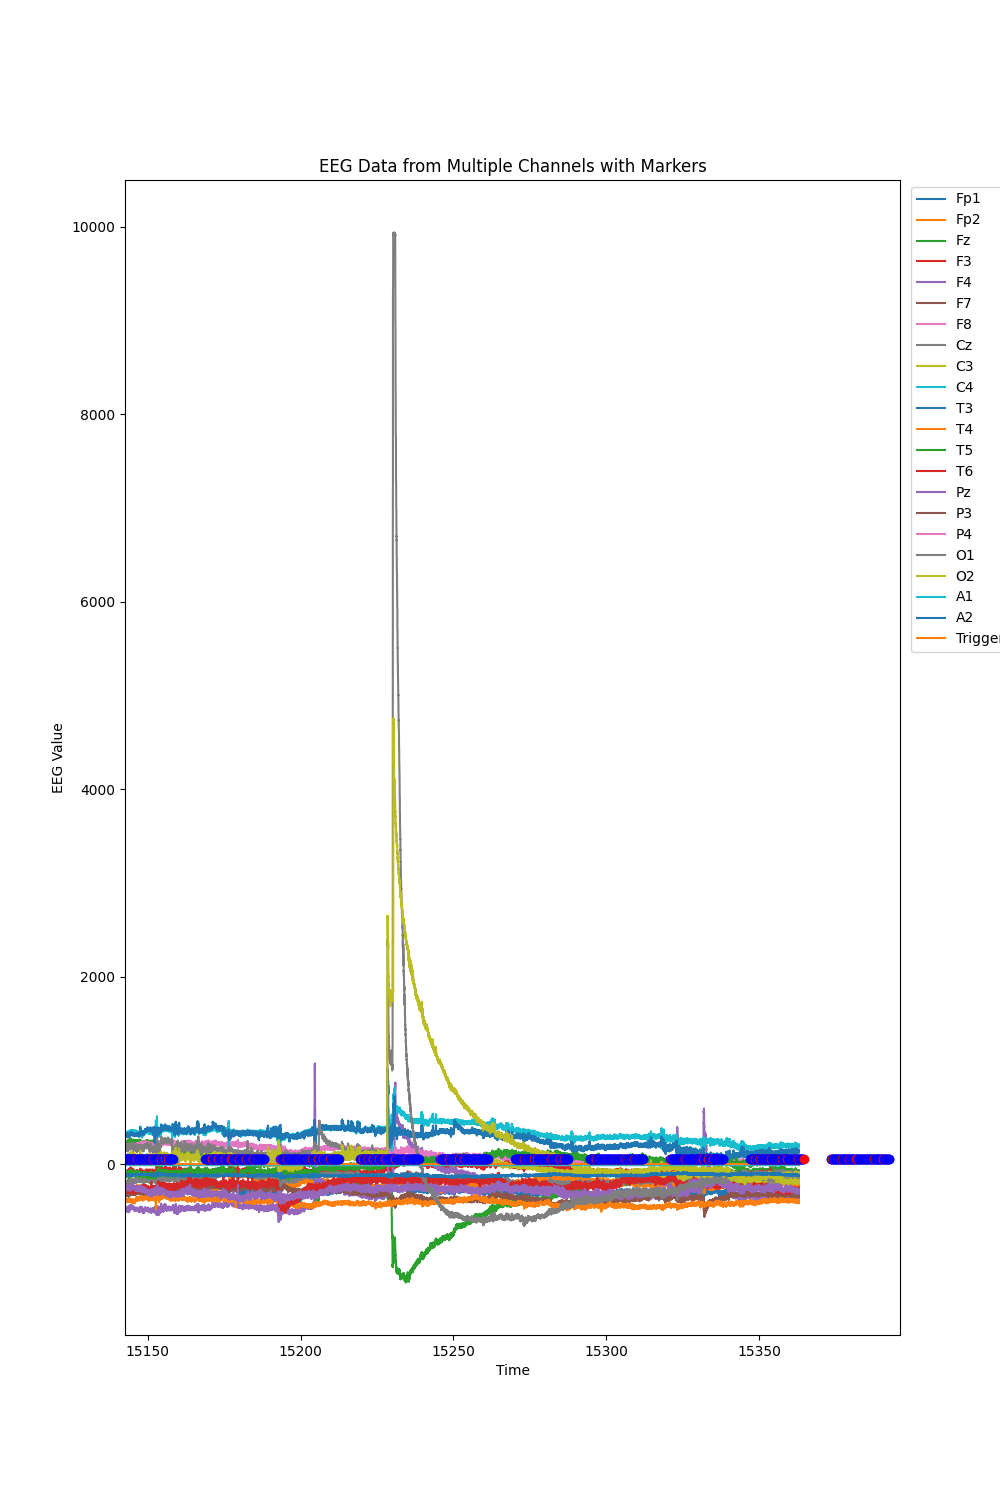

In [215]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipympl
import numpy as np

# Enable interactive plots
    
%matplotlib widget

# Load the data
eeg_data = pd.read_csv('./2024-06-11 13-48-58_EEG_01_15_Hz.csv')
markers = pd.read_csv('./2024-06-11 13-48-58_markers.csv')


# Display the first few rows of each dataframe to understand their structure
# print(eeg_data.head())
# print(markers.head())



# rename columns
electrode_names = ['Col','Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8', 'Cz', 'C3', 'C4', 'T3', 'T4', 'T5', 'T6','Pz', 'P3', 'P4', 'O1', 'O2', 'A1', 'A2', 'Unsure', 'Unsure1', 'Trigger', 'time_stamps']
eeg_data.columns = electrode_names 
# eeg_data = eeg_data.drop(columns=['Unsure', 'Unsure1', 'Trigger'])


# Assuming the EEG data has columns named 'Channel1', 'Channel2', ..., 'Channel24' and 'Time'
channel_columns = eeg_data.columns[1:-1]  # All columns except the first last one
time_column = eeg_data.columns[-1]  # The last column


# Slice the data to plot every 100th row
eeg_data_sliced = eeg_data #.iloc[::10, :]


# assign labels to marker columns
markers.columns = [' ', 'Marker', 'Time']

# Plot the EEG data for all channels
plt.figure(figsize=(10, 15))

for index, channel in enumerate(channel_columns):
    if ((index+1) != 22 and (index+1) != 23):
        plt.plot(eeg_data_sliced[time_column], eeg_data_sliced[channel], label=channel)

# Mark events on the EEG plot
for index, row in markers.iterrows():
    if (len(row['Marker']) == 12): # isolate p300 markers (not 0, Trial Started, Trial Ended)
        if (str(row['Marker'])[9] == str(row['Marker'])[11]): # check if chosen stimulus is the one in the marker (to see p300 responses)
            plt.plot(row['Time'], 50, marker='o', color='r', linestyle='--')
        else:
            plt.plot(row['Time'], 50, marker='o', color='b', linestyle='--')



# Set x-axis limit 
plt.xlim(left=markers.iloc[1,-1], right=markers.iloc[-1,-1])


plt.xlabel('Time')
plt.ylabel('EEG Value')
plt.title('EEG Data from Multiple Channels with Markers')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


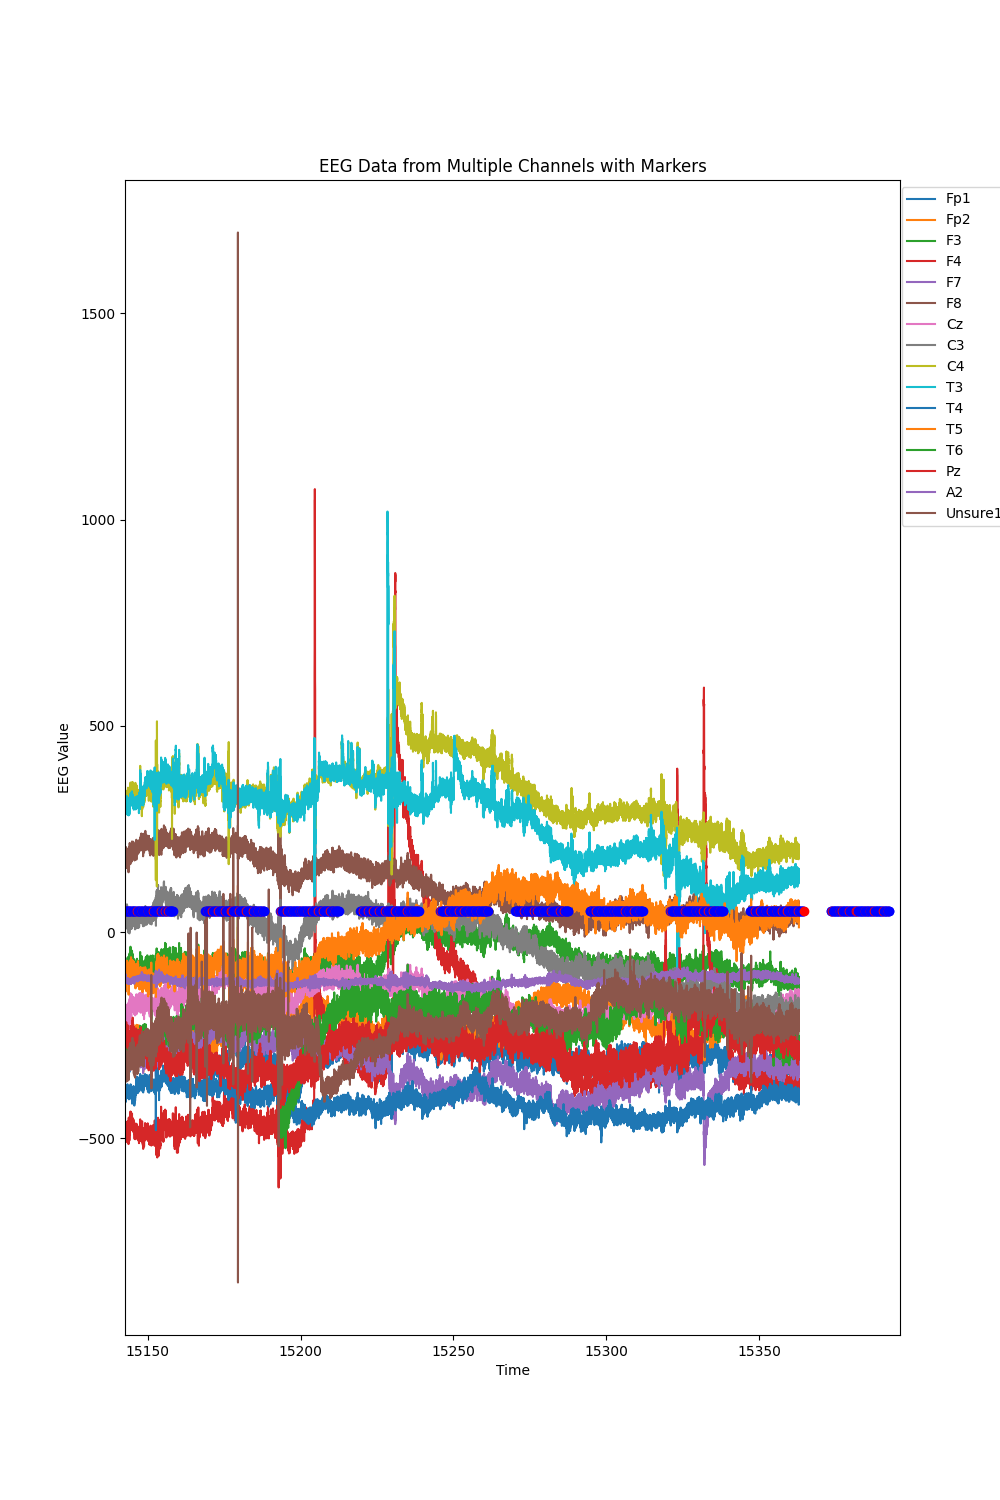

In [216]:
# Define a function to identify bad channels based on variance (MAY NEED TO CHANGE EACH TIME TOO)

from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.filter import filter_data
from mne.channels import make_standard_montage


def identify_bad_channels(eeg_data, high_threshold=50000.0, low_threshold=50):
    variances = eeg_data.var(axis=0)
    bad_channels = variances[(variances > high_threshold) | (variances < low_threshold)].index
    return bad_channels

# Identify bad channels
bad_channels = identify_bad_channels(eeg_data[channel_columns])

# Remove bad channels from the data
eeg_data_filtered = eeg_data.drop(columns=bad_channels)
channel_columns_filtered = eeg_data_filtered.columns[1:-1]  # Update channel columns after filtering

# Plot the EEG data for all channels
plt.figure(figsize=(10, 15))

for index, channel in enumerate(channel_columns_filtered):
    if ((index+1) != 22 and (index+1) != 23):
        plt.plot(eeg_data_filtered[time_column], eeg_data_filtered[channel], label=channel)

# Mark events on the EEG plot
for index, row in markers.iterrows():
    if (len(row['Marker']) == 12): # isolate p300 markers (not 0, Trial Started, Trial Ended)
        if (str(row['Marker'])[9] == str(row['Marker'])[11]): # check if chosen stimulus is the one in the marker (to see p300 responses)
            plt.plot(row['Time'], 50, marker='o', color='r', linestyle='--')
        else:
            plt.plot(row['Time'], 50, marker='o', color='b', linestyle='--')



# Set x-axis limit 
plt.xlim(left=markers.iloc[1,-1], right=markers.iloc[-1,-1])

plt.xlabel('Time')
plt.ylabel('EEG Value')
plt.title('EEG Data from Multiple Channels with Markers')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()


In [252]:
from scipy.stats import ttest_ind
import pywt

# Define a function to create epochs around markers
def create_epochs(eeg_data, markers, epoch_duration=1.0, sampling_rate=300):
    epochs = []
    half_epoch_samples = int(epoch_duration * sampling_rate / 2)
    time_column = eeg_data.columns[-1]
    
    for index, marker in markers.iterrows():
        if (len(marker['Marker']) == 12):
            marker_time = marker['Time']
            # Find the closest time point in the EEG data
            closest_idx = (np.abs(eeg_data[time_column] - marker_time)).argmin()
            
            # Get the start and end indices for the epoch
            #start_idx = max(0, closest_idx - half_epoch_samples)
            start_idx = max(0, closest_idx) # start at stimulus
            end_idx = min(len(eeg_data), closest_idx + half_epoch_samples)
    
            
            # Extract the epoch
            epoch_data = eeg_data.iloc[start_idx:end_idx].copy()
            epoch = {"Data": epoch_data}
            if (str(marker['Marker'])[9] == str(marker['Marker'])[11]): # check if chosen stimulus is the one in the marker (to see p300 responses)
                epoch["Colour"] = "Red"
            else:
                epoch["Colour"] = "Black"
                
            epochs.append(epoch)
    
    return epochs

def perform_dwt(data, wavelet='db4', level=2):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs


sampling_rate = 300  # Assuming a sampling rate of 256 Hz
epochs = create_epochs(eeg_data_filtered, markers, epoch_duration=1.0, sampling_rate=sampling_rate)


#acceptable_channels = ['Fp1', 'Fp2', 'Fz', 'F3', 'F4', 'F7', 'F8','Pz', 'P3', 'P4', 'O1', 'O2']
acceptable_channels =  ['Fp1', 'F3', 'F8', 'Cz', 'C3', 'T5', 'T6','Pz']

curr_samples = samples
wavelet_dict = {}
wavelet_dict[0] = []
wavelet_dict[1] = []
wavelet_dict[2] = []
wavelet_dict[3] = []
wavelet_dict[4] = []
total_sample_list = []
label_list = []
channels_used = []


# iterate through each epoch for the channel
for epoch_index, epoch in enumerate(epochs):
    
    overall_max_min_list = []
    
    for ind, channel in enumerate(channel_columns_filtered):

        max_min_list = []
    
        if channel not in acceptable_channels:
            continue
        if channel not in channels_used:
            channels_used.append(channel)
    
        inserted_index = 0
    
        # get channel epoch and do baseline correction
        new_val = epoch["Data"][channel].values
        new_val -= epoch["Data"][channel].mean()
    
        coeffs = perform_dwt(new_val)
        detail_coeffs = coeffs[1]

        detail_coeffs_2 = coeffs[2]

        # print(len(detail_coeffs))
        # print(len(detail_coeffs_2))
        if len(detail_coeffs) != 42 or len(detail_coeffs_2) != 78:
            break

        detail_coeffs = np.concatenate([detail_coeffs, detail_coeffs_2])
        wavelet_dict[0] = detail_coeffs[0:24]
        wavelet_dict[1] = detail_coeffs[24:48]
        wavelet_dict[2] = detail_coeffs[48:72]
        wavelet_dict[3] = detail_coeffs[72:96]
        wavelet_dict[4] = detail_coeffs[96:120]
    
        for i in range(0,5):
            max_min_list.append([max(wavelet_dict[i]), min(wavelet_dict[i])])
        overall_max_min_list.append(max_min_list)

        

    # only add sample if it has desired shape, add add label as well
    #print(np.array(overall_max_min_list).shape)
    
    desired_shape = (8,5,2)
    if (np.array(overall_max_min_list).shape) == desired_shape:
        total_sample_list.append(overall_max_min_list)

        if epoch["Colour"] == "Red":
            label_list.append(1)
        elif epoch["Colour"] == "Black":
            label_list.append(0)

        
print("Channels used: ", channels_used)
print("Sample Array Shape: ", np.array(total_sample_list).shape)
print("Label Array Shape: ", np.array(label_list).shape)
print("Non P300 Count: ",label_list.count(0))
print("P300 Count: " ,label_list.count(1))




Channels used:  ['Fp1', 'F3', 'F8', 'Cz', 'C3', 'T5', 'T6', 'Pz']
Sample Array Shape:  (808, 8, 5, 2)
Label Array Shape:  (808,)
Non P300 Count:  719
P300 Count:  89


C:\Users\GRHRehabTech\bci_beats_project\BCI-Beats-Forked\venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [253]:
# do KPCA
from sklearn.decomposition import KernelPCA

# Assume feature_vectors is a list of 2x5x6 feature vectors
# Flatten each 2x5x6 feature vector to a 1-D vector of length 60
feature_vectors = np.array(total_sample_list)
flattened_feature_vectors = [f.flatten() for f in feature_vectors]
print("Shape of flattened feature vectors: ", np.array(flattened_feature_vectors).shape)


# Convert the list to a DataFrame
df = pd.DataFrame(flattened_feature_vectors)

# Apply KPCA to reduce dimensionality to 3
kpca = KernelPCA(n_components=3, kernel='rbf') 
transformed_features = kpca.fit_transform(df)

# The transformed_features now has shape (num_samples, 3)
print("Transformed Features Shape:", transformed_features.shape)

Shape of flattened feature vectors:  (808, 80)
Transformed Features Shape: (808, 3)


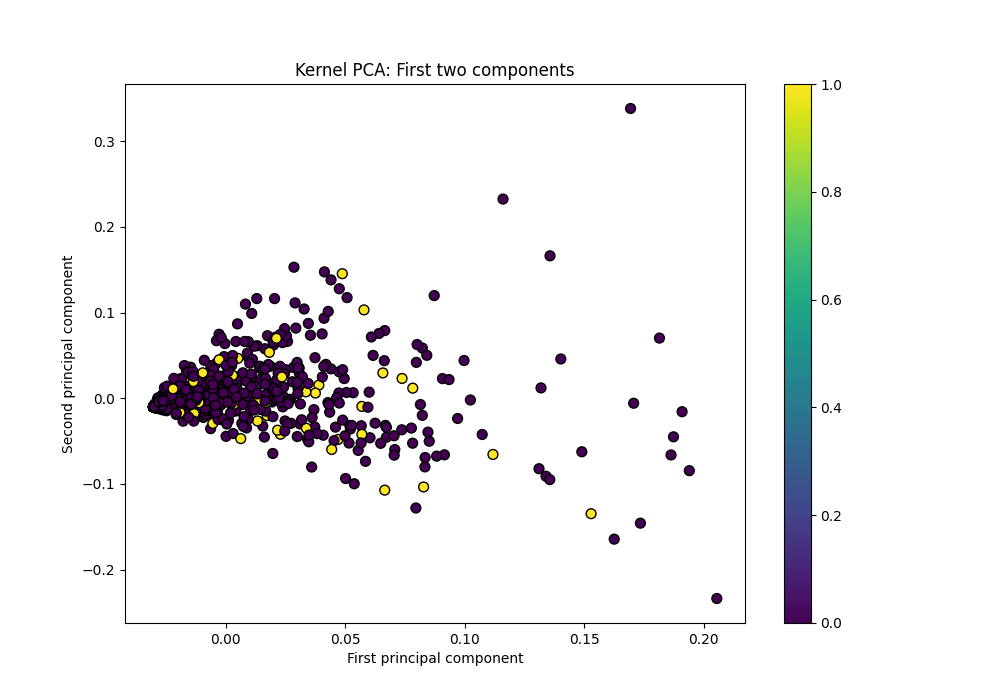

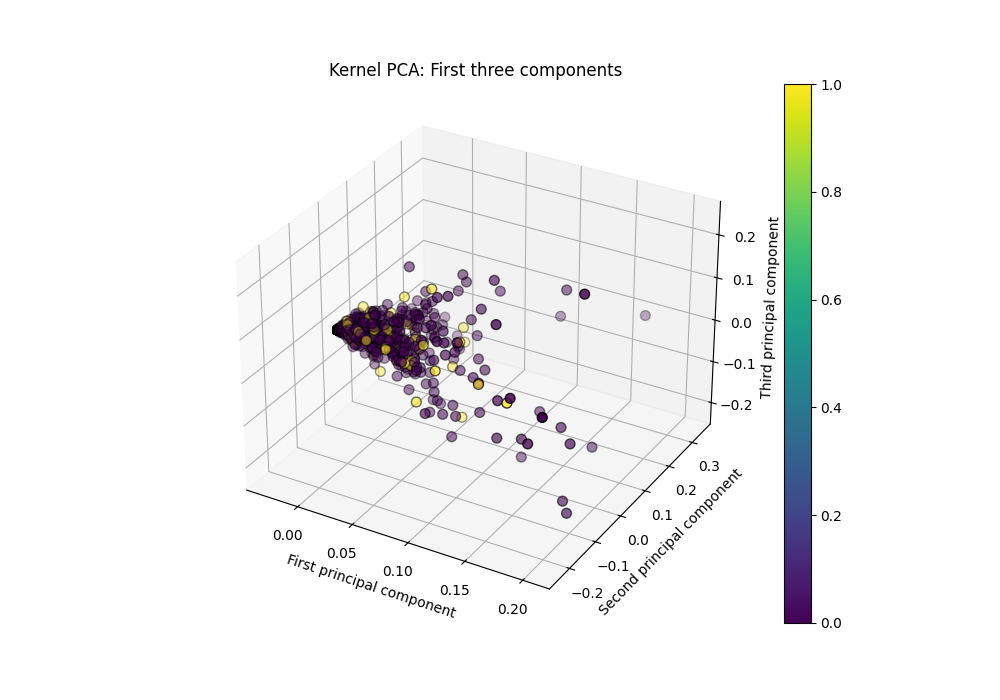

In [254]:
# Visualize KPCA

from matplotlib.colors import ListedColormap

# Plot the first two components
plt.figure(figsize=(10, 7))
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=label_list, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Kernel PCA: First two components')
plt.colorbar()
plt.show()


# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(transformed_features[:, 0], transformed_features[:, 1], transformed_features[:, 2], c=label_list, cmap='viridis', edgecolor='k', s=50)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.title('Kernel PCA: First three components')
plt.colorbar(sc)
plt.show()

In [251]:

# do SVM Classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming labels is a list where 1 represents P300 and 0 represents non-P300
labels = np.array(label_list)  # Ensure labels is a NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_features, labels, test_size=0.2, random_state=42)

# Create and train the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[143   0]
 [ 19   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       143
           1       0.00      0.00      0.00        19

    accuracy                           0.88       162
   macro avg       0.44      0.50      0.47       162
weighted avg       0.78      0.88      0.83       162


Accuracy Score:
0.8827160493827161


C:\Users\GRHRehabTech\bci_beats_project\BCI-Beats-Forked\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\GRHRehabTech\bci_beats_project\BCI-Beats-Forked\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\GRHRehabTech\bci_beats_project\BCI-Beats-Forked\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [ ]:
# # Function to perform DWT and return the coefficients
# def perform_dwt(data, wavelet='db4', level=2):
#     coeffs = pywt.wavedec(data, wavelet, level=level)
#     return coeffs

# # Perform DWT on a single channel (e.g., 'Fp1')
# channel_data = eeg_data['Pz']
# coeffs = perform_dwt(channel_data)


# # # Plot the EEG data for all channels
# # plt.figure(figsize=(10, 15))

# # for index, channel in enumerate(channel_columns):
# #     if ((index+1) != 22 and (index+1) != 23):
# #         plt.plot(eeg_data_sliced[time_column], eeg_data_sliced[channel], label=(index+1))

# # Plot the original EEG data for the selected channel
# plt.figure(figsize=(10, 4))
# plt.plot(eeg_data[time_column], channel_data, label='Pz')
# plt.xlabel('Time')
# plt.ylabel('EEG Value')
# plt.title('EEG Data from Channel Pz')
# plt.legend(loc='upper right')
# plt.xlim(left=markers.iloc[1,-1], right=markers.iloc[-1,-1])
# plt.show()


# # Plot the wavelet coefficients
# plt.figure(figsize=(12, 8))
# for i, coeff in enumerate(coeffs):
#     plt.subplot(len(coeffs), 1, i + 1)
#     plt.plot(coeff, label=f'Level {i} Coefficients')
#     plt.legend(loc='upper right')
#     plt.title(f'Wavelet Coefficients - Level {i}')

# plt.tight_layout()
# plt.show()